# 1. Introduction

<div style="background-color: #e6f7ff; padding: 10px;">
This analysis is based on a comprehensive global energy dataset covering the years 2000 to 2020. The dataset covers areas including (clean) energy and economic factors, along with geographic and demographic data for countries. This project focuses on examining global energy trends, with an emphasis on identifying disparities and opportunities for future investments. The analysis addresses three key research questions:

    1. How has access to electricity and clean cooking fuels evolved from 2000 to 2020 across selected categories? And what is the potential for these access to grow by categories?

    To answer this, time-series data on energy access was analyzed across selected (transformed) features. Feature engineering and visualization techniques were used to provide insights into the regions with the greatest disparities in access and those making the most progress, helping to inform policy and investment priorities.


    2. How does electricity composition vary across regions? Can additional features help cluster countries into meaningful categories?

    Focusing on electricity composition across regions, KMeans clustering was applied using additional features such as electricity sources, CO2 emissions, GDP growth, and geographic factors. The clustering analysis identified distinct country groups with common opportunities and challenges.


    3. How have developing countries that receive financial aid for renewable energy development performed?

    The analysis assessed the situation of receiving countries, investigating the impact of past financial aid on renewable energy growth using OLS regression while considering GDP per capita and energy intensity. In addition, Lasso and Random Forest models were employed to predict future renewable energy shares, capturing both linear and non-linear patterns in the data.


This project is organized into three parts: Part 1 provides an introduction which outlines the research questions, Part 2 presents the code and detailed analysis, and Part 3 concludes by summarizing the key findings and insights drawn from the analysis.
</div>

# 2. Codes and Details

# 2.1 Preparing the Data Set and Packages

In [1]:
!pip install country_converter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import country_converter as coco


from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import scipy.stats as stats

import statsmodels.api as sm


from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec

import textwrap  

import matplotlib.ticker as ticker

In [2]:
# Import data
data = pd.read_csv('data_sustainable_energy.csv')

# Initialize country converter
cc = coco.CountryConverter()

# Create a new column 'Region' that maps countries to their respective region （continent）
data['Region'] = cc.convert(names=data['Entity'], to='continent')

# Display the first few rows of the country and region mapping
data[['Entity', 'Region']].head()


# Latitude clustering (High, Mid, Low)
def classify_latitude(lat):
    if lat > 60:
        return 'High Latitude'
    elif 30 <= lat <= 60:
        return 'Mid Latitude'
    else:
        return 'Low Latitude'

data['LatitudeCluster'] = data['Latitude'].apply(classify_latitude)

# Population Density clustering (High, Mid, Low)
def classify_population_density(density):
    if density > 300:
        return 'High Density'
    elif 50 <= density <= 300:
        return 'Mid Density'
    else:
        return 'Low Density'

#Convert the 'Density (P/Km2)' column to numeric, handling errors (e.g., missing values or non-numeric entries)
data['Density (P/Km2)'] = pd.to_numeric(data['Density (P/Km2)'], errors='coerce')
data['PopulationDensityCluster'] = data['Density (P/Km2)'].apply(classify_population_density)

# Land Area clustering (High, Mid, Low)
def classify_land_area(area):
    if area > 500000:
        return 'High Land Area'
    elif 50000 <= area <= 500000:
        return 'Mid Land Area'
    else:
        return 'Low Land Area'

data['LandAreaCluster'] = data['Land Area(Km2)'].apply(classify_land_area)

#print(data)

<div style="background-color: #e6f7ff; padding: 10px;">
I did this clustering because I have data on the latitude, population density, and land area of different countries. I used popular and well-established criteria for clustering countries based on four important dimensions:
    

**1. Region**: Countries are categorized by their respective continents (e.g., Africa, Asia, Europe). This regional grouping is helpful for understanding global patterns in energy use and access.


**2. Latitude**: Latitude is a crucial factor because it can significantly affect a country's energy potential. The countries are grouped into three latitude bands:

    • High latitude: Countries above 60° latitude.

    • Mid latitude: Countries between 30° and 60° latitude.

    • Low latitude: Countries below 30° latitude. 


**3. Population Density**: Population density can influence energy infrastructure needs and efficiency. I divided countries based on their population density (people per square kilometer):

    • High density: Greater than 300 people/km².

    • Mid density: Between 50 and 300 people/km².

    • Low density: Fewer than 50 people/km². 


**4. Land Area**: Land area impacts the geographic spread of energy distribution, energy resource availability, and potential for expansion. Countries are clustered based on land area:

    • High land area: Greater than 500,000 square kilometers.

    • Mid land area: Between 50,000 and 500,000 square kilometers.

    • Low land area: Less than 50,000 square kilometers. 



These clusters provide valuable insights into the characteristics of different countries and allow for feature engineering that will be useful in the later stages of the project, especially when applying more sophisticated clustering methods. Clustering countries in this way enables the identification of patterns and relationships that are not immediately apparent when looking at the raw data alone. It also helps tailor energy solutions and policies to countries based on their geographic and demographic profiles.

</div>

# 2.2 Check Missing Values in the Data Set

<div style="background-color: #e6f7ff; padding: 10px;">
In this part, I checked the dataset for missing values. Columns with missing data below the 10% threshold were considered acceptable, while columns with higher levels of missing data were flagged for further consideration.

For instance, "Financial flows to developing countries" had a substantial percentage of missing values, but this was expected because only a part of developing countries have received these financial aids. As a result, this missing data was not considered problematic. However, for columns like "Renewable energy share in total final energy consumption" which had significant missing data.

To ensure the robustness of the analysis, I focused on features with complete or nearly complete data and addressed the missing values through imputation where appropriate.
</div>

In [3]:
# Check for missing values in the entire dataset
# 3649 rows, 5% corresponds to 183 rows, 10% corresponds to 365 rows
missing_values = data.isnull().sum()

print('The colummns with acceptable missing values (below 10%):')
missing_values[missing_values <= 365]

The colummns with acceptable missing values (below 10%):


Entity                                                                0
Year                                                                  0
Access to electricity (% of population)                              10
Access to clean fuels for cooking                                   169
Renewable energy share in the total final energy consumption (%)    194
Electricity from fossil fuels (TWh)                                  21
Electricity from nuclear (TWh)                                      126
Electricity from renewables (TWh)                                    21
Low-carbon electricity (% electricity)                               42
Primary energy consumption per capita (kWh/person)                    0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         207
gdp_growth                                                          317
gdp_per_capita                                                      282
Density (P/Km2)                                                 

In [4]:
#Display only the columns with missing values larger than 10%
print('The colummns with significant missing values (above 10%):')
missing_values[missing_values > 365]

The colummns with significant missing values (above 10%):


Renewable-electricity-generating-capacity-per-capita     931
Financial flows to developing countries (US $)          2089
Value_co2_emissions_kt_by_country                        428
Renewables (% equivalent primary energy)                2137
dtype: int64

# 2.3 Research Questions

# 2.3.1 Access to Energy

<div style="background-color: #e6f7ff; padding: 10px;">
This section addresses how access to electricity and clean cooking fuels has evolved from 2000 to 2020, focusing on disparities across regions and geographic categories. The analysis is divided into two main parts:

    1. Energy Access Over Time: This includes visualizing access to electricity and clean fuels over time by region, land area, population density, and latitude. The methodology involves time-series analysis using line plots to track trends across these factors.
    
    2. Investment Potential: Using 2020 data, this part identifies regions with low energy access but high renewable energy potential, offering insights into areas suitable for future investments.
Feature engineering and visualization are key methodologies here, enabling us to explore how these factors influence access to energy and where progress has been most significant.
</div>

# 2.3.1A Energy Access Over Time

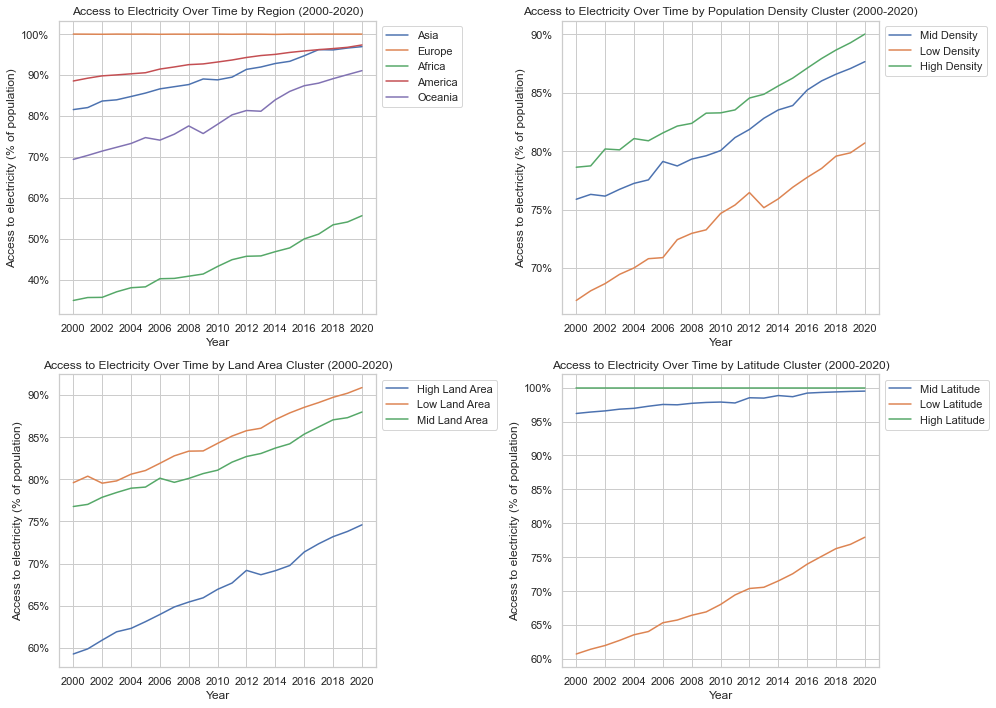

In [5]:
# Function to format y-axis as percentage
def percentage_format(x, pos):
    return f'{x:.0f}%'

# Set Seaborn style for aesthetic plots
sns.set(style="whitegrid")

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10)) 

# 1. Access to electricity over time by Region
sns.lineplot(x='Year', y='Access to electricity (% of population)', hue='Region', data=data, ci=None, ax=axes[0, 0])
axes[0, 0].set_xticks(range(2000, 2021, 2))
axes[0, 0].yaxis.set_major_formatter(FuncFormatter(percentage_format))

axes[0, 0].set_title('Access to Electricity Over Time by Region (2000-2020)')
axes[0, 0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# 2. Access to electricity over time by Population Density Cluster
sns.lineplot(x='Year', y='Access to electricity (% of population)', hue='PopulationDensityCluster', data=data, ci=None, ax=axes[0, 1])
axes[0, 1].set_xticks(range(2000, 2021, 2))
axes[0, 1].yaxis.set_major_formatter(FuncFormatter(percentage_format))
axes[0, 1].set_title('Access to Electricity Over Time by Population Density Cluster (2000-2020)')
axes[0, 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# 3. Access to electricity over time by Land Area Cluster
sns.lineplot(x='Year', y='Access to electricity (% of population)', hue='LandAreaCluster', data=data, ci=None, ax=axes[1, 0])
axes[1, 0].set_xticks(range(2000, 2021, 2))
axes[1, 0].yaxis.set_major_formatter(FuncFormatter(percentage_format))
axes[1, 0].set_title('Access to Electricity Over Time by Land Area Cluster (2000-2020)')
axes[1, 0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# 4. Access to electricity over time by Latitude Cluster
sns.lineplot(x='Year', y='Access to electricity (% of population)', hue='LatitudeCluster', data=data, ci=None, ax=axes[1, 1])
axes[1, 1].set_xticks(range(2000, 2021, 2))
axes[1, 1].yaxis.set_major_formatter(FuncFormatter(percentage_format))
axes[1, 1].set_title('Access to Electricity Over Time by Latitude Cluster (2000-2020)')
axes[1, 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and spacing
plt.tight_layout()
plt.show()

<div style="background-color: #e6f7ff; padding: 10px;">
Key Insights from the Visuals:

    1. Access to Electricity Over Time by Region: This plot shows how access to electricity has improved in different regions from 2000 to 2020. While most regions like Europe and Asia have high levels of access, Africa shows slower progress, with a lower percentage of the population having access over time.

    2. Access to Electricity Over Time by Population Density: Countries with high population density tend to have better electricity access, as seen by the higher percentage of the population connected to the grid compared to lower-density regions.

    3. Access to Electricity Over Time by Land Area: Countries with smaller land areas show higher access to electricity, likely due to the ease of infrastructure development in compact spaces, while larger countries tend to face more challenges in achieving widespread access.

    4. Access to Electricity Over Time by Latitude: The data shows that countries located at lower latitudes (closer to the equator) have made more significant improvements in electricity access compared to those at higher latitudes.

</div>

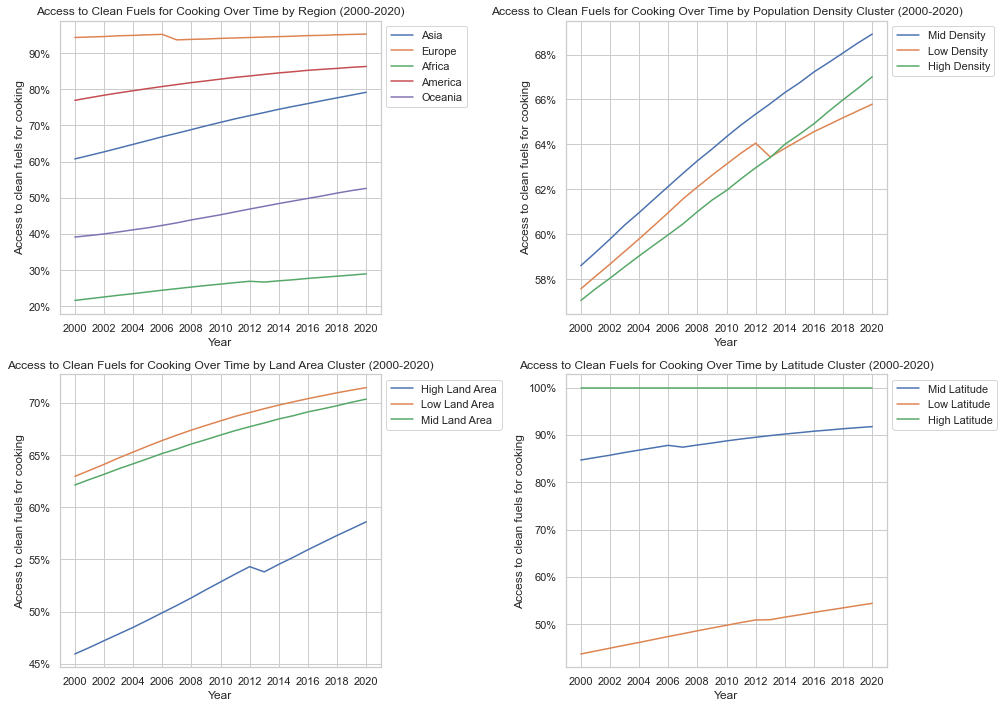

In [6]:
# Function to format y-axis as percentage
def percentage_format(x, pos):
    return f'{x:.0f}%'

# Set Seaborn style for aesthetic plots
sns.set(style="whitegrid")

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10)) 

# 1. Access to clean fuels for cooking over time by Region
sns.lineplot(x='Year', y='Access to clean fuels for cooking', hue='Region', data=data, ci=None, ax=axes[0, 0])
axes[0, 0].set_xticks(range(2000, 2021, 2))
axes[0, 0].yaxis.set_major_formatter(FuncFormatter(percentage_format))
axes[0, 0].set_title('Access to Clean Fuels for Cooking Over Time by Region (2000-2020)')
axes[0, 0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# 2. Access to clean fuels for cooking over time by Population Density Cluster
sns.lineplot(x='Year', y='Access to clean fuels for cooking', hue='PopulationDensityCluster', data=data, ci=None, ax=axes[0, 1])
axes[0, 1].set_xticks(range(2000, 2021, 2))
axes[0, 1].yaxis.set_major_formatter(FuncFormatter(percentage_format))
axes[0, 1].set_title('Access to Clean Fuels for Cooking Over Time by Population Density Cluster (2000-2020)')
axes[0, 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# 3. Access to clean fuels for cooking over time by Land Area Cluster
sns.lineplot(x='Year', y='Access to clean fuels for cooking', hue='LandAreaCluster', data=data, ci=None, ax=axes[1, 0])
axes[1, 0].set_xticks(range(2000, 2021, 2))
axes[1, 0].yaxis.set_major_formatter(FuncFormatter(percentage_format))
axes[1, 0].set_title('Access to Clean Fuels for Cooking Over Time by Land Area Cluster (2000-2020)')
axes[1, 0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# 4. Access to clean fuels for cooking over time by Latitude Cluster
sns.lineplot(x='Year', y='Access to clean fuels for cooking', hue='LatitudeCluster', data=data, ci=None, ax=axes[1, 1])
axes[1, 1].set_xticks(range(2000, 2021, 2))
axes[1, 1].yaxis.set_major_formatter(FuncFormatter(percentage_format))
axes[1, 1].set_title('Access to Clean Fuels for Cooking Over Time by Latitude Cluster (2000-2020)')
axes[1, 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and spacing
plt.tight_layout()
plt.show()


<div style="background-color: #e6f7ff; padding: 10px;">
Key Insights from the Visuals:

    1. Access to Clean Fuels for Cooking by Region (2000-2020): Regions like Europe and America show high access to clean cooking fuels, while Africa lags behind significantly, with less than 30% of the population having access by 2020.

    2. Clean Cooking Fuel Access by Population Density: Countries with mid population densities have greater access to clean cooking fuels.

    3. Clean Cooking Fuel Access by Land Area: Countries with smaller land areas show better access to clean cooking fuels.

    4. Clean Cooking Fuel Access by Latitude: Countries located in lower latitudes show significantly less access to clean cooking fuels compared to those in mid and high latitudes, indicating geographic disparities in clean fuel availability.
</div>

# 2.3.1B Investment Potential

In [22]:
# Filter the dataset for the year 2020
data_2020 = data[data['Year'] == 2020]

# Identify regions/countries with low energy access but high renewable potential (e.g., large land area, high latitude)
# Calculate the summary stats for each cluster using 2020 data only
potential_investment_2020 = data_2020.groupby(['Region', 'LandAreaCluster', 'PopulationDensityCluster'])[['Access to electricity (% of population)', 'Access to clean fuels for cooking']].mean()

# Round values for better readability and format the table
potential_investment_2020 = potential_investment_2020.round(2)

# Use Pandas Styler to format the table for better readability and understanding
styled_table_2020 = potential_investment_2020.style.set_caption('Average Energy Access by Region, Land Area, and Population Density Cluster (2020)')\
    .background_gradient(cmap='Blues')\
    .format({'Access to electricity (% of population)': '{:.2f}%', 'Access to clean fuels for cooking': '{:.2f}%'})\
    .set_table_styles([{
        'selector': 'caption',
        'props': [('color', 'black'), ('font-size', '16px'), ('font-weight', 'bold')]
    }])

# Display the styled table in a readable format for non-technical colleagues
styled_table_2020


<div style="background-color: #e6f7ff; padding: 10px;">
The heatmap and preceding plots together provide a comprehensive overview of energy access across different regions, land areas, population densities, and latitudes in 2020. Darker blue highlights regions with higher access to energy, while lighter blue shows lower access, making it visually intuitive.

    1. Electricity Access:

    • Regional Disparities: Europe, Asia, and parts of the Americas show near-universal access to electricity, while regions in Africa and Oceania lag behind. Countries in Africa, particularly those with low population densities and large land areas, exhibit the lowest levels of access, with electricity access as low as 48.88% in certain clusters.

    • Land Area and Density Impact: Small land area countries generally perform better, while low-density areas, particularly in Africa and Oceania, consistently show lower access to electricity.


    2. Access to Clean Cooking Fuels:

    • Significant Disparities: Access to clean fuels for cooking remains a major challenge, particularly in low-density areas of Africa and Oceania, where access is below 30%. In contrast, regions such as Europe and parts of Asia show high access rates, often exceeding 90%.

    • Land Area and Population Density: Similar to electricity access, countries with smaller land areas and higher population densities tend to have better access to clean cooking fuels, highlighting infrastructure challenges faced by larger, sparsely populated countries.


    3. Overall Patterns:

    • High vs. Low Performers: Regions with smaller land areas and higher population densities, such as those in Asia and Europe, perform significantly better in both electricity access and clean cooking fuel access compared to regions like Africa and Oceania.

    •Impact of Geographic and Demographic Factors: Clusters based on population density, land area, and latitude reveal that geographic and demographic factors play a crucial role in determining a country’s energy access. High-density, mid-latitude countries fare better, while low-density regions in Africa and Oceania face significant barriers.
</div>

# 2.3.2 Electricity Composition and Clustering


<div style="background-color: #e6f7ff; padding: 10px;">
This section focuses on the electricity composition across regions and the application of clustering methods to group countries based on their energy mix. The section is broken into:

    1. Electricity Composition Analysis: This includes tracking the share of fossil fuels, renewables, and nuclear energy over time for different regions.

    2. Clustering Countries: K-Means (K = 4) clustering is applied to a set of features, including electricity sources, gross CO2 emission, GDP growth, energy intensity and geographic factors. The objective is to identify patterns that reveal commons within these groups.
    
The methodology integrates statistical analysis, clustering techniques, and visualization to explore how countries' electricity profiles vary and what these clusters reveal about regional energy dynamics.
</div>

# 2.3.2A Electricity Composition Analysis

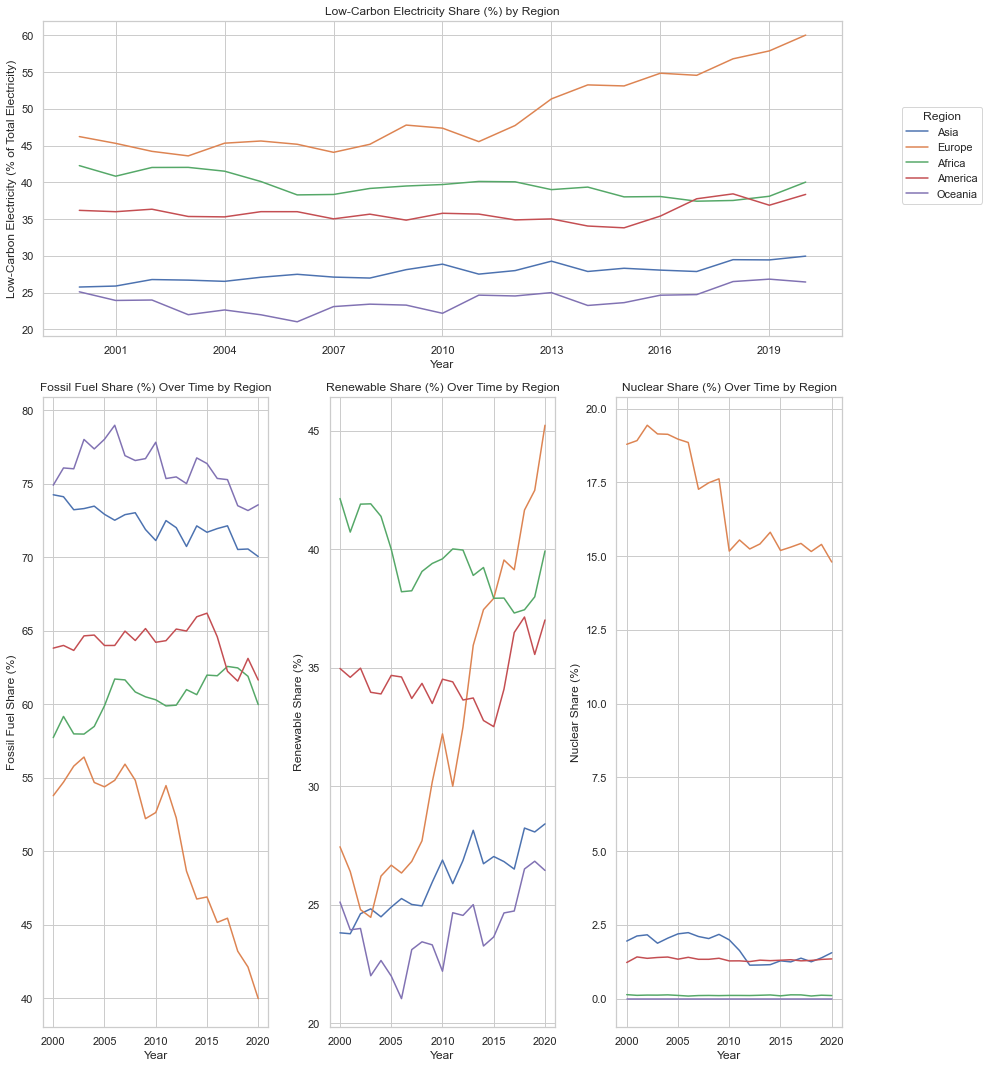

In [8]:
# Step 1: Drop rows with missing values in key electricity-related columns
electricity_time_data = data.dropna(subset=[
    'Electricity from fossil fuels (TWh)',
    'Electricity from renewables (TWh)',
    'Electricity from nuclear (TWh)',
    'Low-carbon electricity (% electricity)',
    'Year', 'Region'
]).copy()

# Step 2: Calculate the total electricity generation for each region and year
electricity_time_data.loc[:, 'Total Electricity (TWh)'] = electricity_time_data['Electricity from fossil fuels (TWh)'] + \
                                                          electricity_time_data['Electricity from renewables (TWh)'] + \
                                                          electricity_time_data['Electricity from nuclear (TWh)']

# Step 3: Calculate the share (weights) of each energy source as a proportion of total electricity
electricity_time_data.loc[:, 'Fossil Fuel Share (%)'] = (electricity_time_data['Electricity from fossil fuels (TWh)'] / 
                                                         electricity_time_data['Total Electricity (TWh)']) * 100

electricity_time_data.loc[:, 'Renewable Share (%)'] = (electricity_time_data['Electricity from renewables (TWh)'] / 
                                                       electricity_time_data['Total Electricity (TWh)']) * 100

electricity_time_data.loc[:, 'Nuclear Share (%)'] = (electricity_time_data['Electricity from nuclear (TWh)'] / 
                                                     electricity_time_data['Total Electricity (TWh)']) * 100

# Step 4: Create a figure with GridSpec layout
fig = plt.figure(figsize=(12, 15))  # Adjust the width for the 1x3 layout
gs = GridSpec(2, 3, height_ratios=[1, 2], figure=fig)  # 2 rows: 1st row for Low-Carbon, 2nd row for 3 plots

# A. Low-Carbon Electricity Share Plot (spans the full top row)
ax0 = fig.add_subplot(gs[0, :])  # Span across all three columns
sns.lineplot(x='Year', y='Low-carbon electricity (% electricity)', hue='Region', data=electricity_time_data, ci=None, ax=ax0)
ax0.set_title('Low-Carbon Electricity Share (%) by Region')
ax0.set_xlabel('Year')
ax0.set_ylabel('Low-Carbon Electricity (% of Total Electricity)')
# Ensure x-axis ticks are integers (Years)
ax0.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax0.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

# B. Fossil Fuel Share Plot (1st plot in the second row)
ax1 = fig.add_subplot(gs[1, 0])
sns.lineplot(x='Year', y='Fossil Fuel Share (%)', hue='Region', data=electricity_time_data, ci=None, ax=ax1)
ax1.set_title('Fossil Fuel Share (%) Over Time by Region')
ax1.set_xlabel('Year')
ax1.set_ylabel('Fossil Fuel Share (%)')

# C. Renewable Share Plot (2nd plot in the second row)
ax2 = fig.add_subplot(gs[1, 1])
sns.lineplot(x='Year', y='Renewable Share (%)', hue='Region', data=electricity_time_data, ci=None, ax=ax2)
ax2.set_title('Renewable Share (%) Over Time by Region')
ax2.set_xlabel('Year')
ax2.set_ylabel('Renewable Share (%)')

# D. Nuclear Share Plot (3rd plot in the second row)
ax3 = fig.add_subplot(gs[1, 2])
sns.lineplot(x='Year', y='Nuclear Share (%)', hue='Region', data=electricity_time_data, ci=None, ax=ax3)
ax3.set_title('Nuclear Share (%) Over Time by Region')
ax3.set_xlabel('Year')
ax3.set_ylabel('Nuclear Share (%)')

# Move the legend outside of the plots
handles, labels = ax0.get_legend_handles_labels()  # Get legend info from the top plot
fig.legend(handles, labels, title='Region', loc='upper right', bbox_to_anchor=(1.15, 0.9))

# Remove individual legends to avoid duplication
ax0.legend_.remove()
ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()

# Adjust layout for tight fit
plt.tight_layout()
plt.show()

<div style="background-color: #e6f7ff; padding: 10px;">
Key Insights from the Visuals:

    This plot shows the percentage of total electricity generated from low-carbon sources (including renewables and nuclear) across different regions. Europe has maintained a higher and increasing share of low-carbon electricity, while Asia and Oceania show significantly lower levels. Asia and America show a steady increase in low-carbon electricity generation, particularly in recent years.

    A. Fossil Fuel Share: Fossil fuel dependency has steadily declined in most regions, especially in Europe, where the reliance on fossil fuels has decreased from around 55% to 40% by 2020. Asia’s share of fossil fuels remains relatively high, with only slight reductions, while America’s fossil fuel share remains fairly stable over time.

    B. Renewable Share: Renewables have experienced notable growth, especially in the last 5 years. In particular, the renewable share in Europe has risen from 25% to over 45%. The Americas exhibit a growth, rising from around 35% to over 48%. Asia and Oceania seen more modest progress, remaining at relatively low levels, though it is trending upwards slowly.

    C. Nuclear Share: Nuclear energy’s contribution to total electricity generation has been relatively low and stable in most regions, except for a sharp decline in Europe after 2010. This decline could be attributed to the phase-out of nuclear plants in countries like Germany, yet Europe still maintains a relatively high nuclear share, around 15%, due to continued reliance in countries such as France. America and Asia maintain low but stable nuclear energy shares, while Africa and Oceania show almost no reliance on nuclear energy throughout the period.
</div>

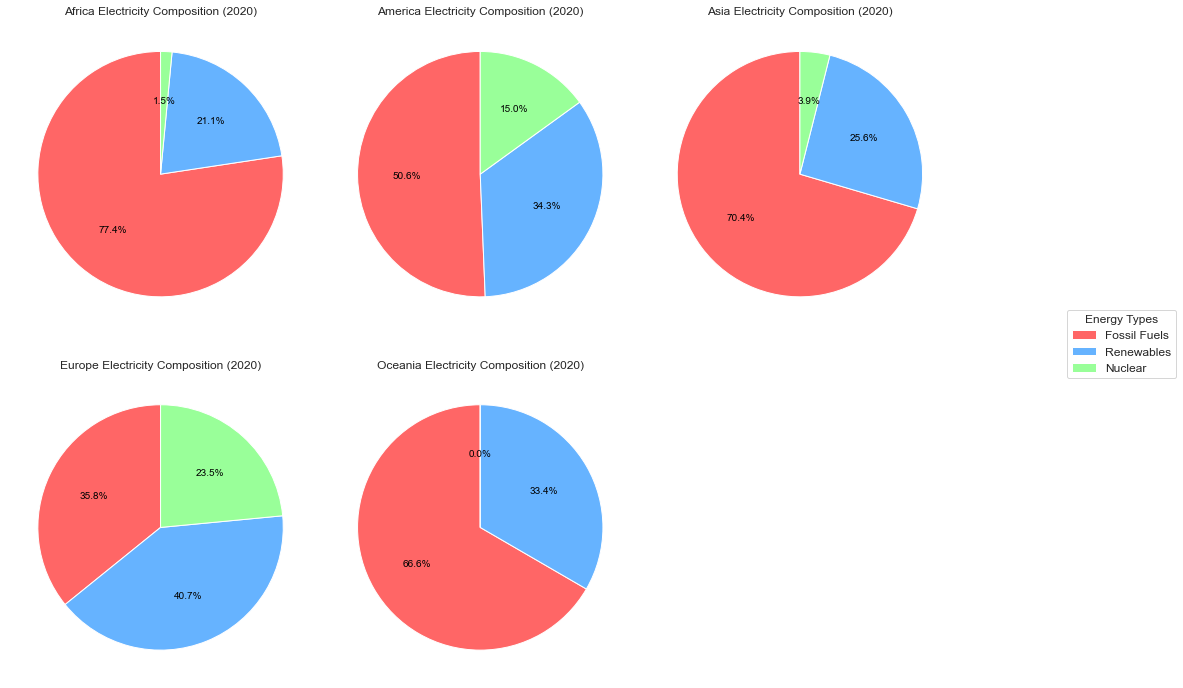

In [9]:
# Group the data by region and aggregate electricity generation for 2020
data_2020 = electricity_time_data[electricity_time_data['Year'] == 2020]

electricity_2020 = data_2020.groupby('Region').agg({
    'Electricity from fossil fuels (TWh)': 'sum',
    'Electricity from renewables (TWh)': 'sum',
    'Electricity from nuclear (TWh)': 'sum'
})

# Define the regions
regions = electricity_2020.index.tolist()

# Create a figure with subplots for each region (2x3 grid layout to accommodate all regions)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# List of distinct colors for the pie charts
colors = ['#ff6666','#66b3ff','#99ff99']

# Loop over the regions and create a pie chart for each
for i, region in enumerate(regions):
    # Get the row index for the current region
    ax = axes[i // 3, i % 3]  # Position the chart in a 2x3 grid
    electricity_sources = electricity_2020.loc[region, ['Electricity from fossil fuels (TWh)', 
                                                        'Electricity from renewables (TWh)', 
                                                        'Electricity from nuclear (TWh)']]
    
    # Plot pie chart without labels inside, just percentages
    wedges, texts, autotexts = ax.pie(electricity_sources, autopct='%1.1f%%', startangle=90, colors=colors, 
                                      textprops=dict(color="black"))

    # Set the font size of the percentage labels
    for autotext in autotexts:
        autotext.set_fontsize(10)
    
    # Set title for each subplot
    ax.set_title(f'{region} Electricity Composition (2020)', fontsize=12)

# Remove empty subplot (in case we have 5 regions in a 2x3 grid)
if len(regions) < 6:
    fig.delaxes(axes[1, 2])  # Delete the last unused subplot if necessary

# Add a shared legend for energy types (fossil fuels, renewables, nuclear)
labels = ['Fossil Fuels', 'Renewables', 'Nuclear']
fig.legend(wedges, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), fontsize=12, title="Energy Types")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make space for the legend on the right
plt.show()


<div style="background-color: #e6f7ff; padding: 10px;">
Key Insights from the Visuals:

    These pie charts illustrate the electricity composition for various regions in 2020. Based on this data, different regions have varying potentials for transitioning toward more sustainable energy, with unique opportunities and challenges:
    
    • Africa and Oceania have the greatest untapped potential for renewable energy. Both regions could benefit from significant investment and international support to transition away from fossil fuels, but infrastructure and political challenges need to be addressed.
    
    • Asia represents a key area of focus for reducing global fossil fuel use due to its reliance on coal. While countries like China and India are making strides in renewable energy, continued support and technological innovation will be critical to overcoming the existing dependence on fossil fuels.
    
    • Europe and the Americas already show strong progress in transitioning to renewables but need to further diversify their energy mix, particularly in scaling up renewable energy and balancing nuclear power sources.
</div>

# 2.3.2B Clustering Countries

<div style="background-color: #e6f7ff; padding: 10px;">

**Method:**
K-Means clustering was used to group countries based on their electricity composition.

**Factors Used:**
The features used for clustering include electricity from fossil fuels, renewables, nuclear energy, CO2 emissions, GDP growth, energy intensity, population density, land area, and latitude. These factors were chosen to capture the diverse energy profiles of countries, helping identify groups with common energy challenges and opportunities for targeted analysis.
    
</div>

In [10]:
# Latitude clustering (High, Mid, Low)
def classify_latitude(lat):
    if lat > 60:
        return 'High'
    elif 30 <= lat <= 60:
        return 'Mid'
    else:
        return 'Low'

# Population Density clustering (High, Mid, Low)
def classify_population_density(density):
    if density > 300:
        return 'High'
    elif 50 <= density <= 300:
        return 'Mid'
    else:
        return 'Low'

# Land Area clustering (High, Mid, Low)
def classify_land_area(area):
    if area > 500000:
        return 'High'
    elif 50000 <= area <= 500000:
        return 'Mid'
    else:
        return 'Low'

# Apply the classification functions
data['LatitudeCluster'] = data['Latitude'].apply(classify_latitude)
data['PopulationDensityCluster'] = data['Density (P/Km2)'].apply(classify_population_density)
data['LandAreaCluster'] = data['Land Area(Km2)'].apply(classify_land_area)

# Step 1: Create a new DataFrame for clustering, to avoid modifying the original DataFrame
df_for_clustering = data.copy()

# Step 2: Reintroduce ordinal encoding for the categorical features
ordinal_mapping = {'Low': 0, 'Mid': 1, 'High': 2}

# Apply ordinal encoding to categorical features in the new DataFrame
df_for_clustering['LatitudeCluster'] = df_for_clustering['LatitudeCluster'].map(ordinal_mapping)
df_for_clustering['PopulationDensityCluster'] = df_for_clustering['PopulationDensityCluster'].map(ordinal_mapping)
df_for_clustering['LandAreaCluster'] = df_for_clustering['LandAreaCluster'].map(ordinal_mapping)

# Step 3: Select necessary features for clustering and check for NaN values
features = df_for_clustering[['Electricity from fossil fuels (TWh)', 
                              'Electricity from renewables (TWh)', 
                              'Electricity from nuclear (TWh)', 
                              'gdp_growth', 
                              'Value_co2_emissions_kt_by_country', 
                              'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 
                              'LatitudeCluster', 
                              'PopulationDensityCluster', 
                              'LandAreaCluster']]

# Step 4: Drop NaN values from the features
features = features.dropna()

# Step 5: Standardize the features before clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 6: Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Step 7: Add cluster labels to the new DataFrame for clustering
data_for_clustering = df_for_clustering.loc[features.index].copy()  # Create a new DataFrame for clustering
data_for_clustering['Cluster'] = clusters  # Assign clusters to rows

# Step 8: Generate cluster summary
summary_columns = ['Electricity from fossil fuels (TWh)', 
                   'Electricity from renewables (TWh)', 
                   'Electricity from nuclear (TWh)', 
                   'gdp_growth', 
                   'Value_co2_emissions_kt_by_country', 
                   'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 
                   'LatitudeCluster', 
                   'PopulationDensityCluster', 
                   'LandAreaCluster']

# Group by clusters and calculate the mean for each feature
cluster_summary = data_for_clustering.groupby('Cluster')[summary_columns].mean()

In [11]:
# Step 9: Drop duplicates based on the country ('Entity') column to ensure each country is listed once per cluster
unique_countries_per_cluster = data_for_clustering.drop_duplicates(subset='Entity')


# Step 10: Print the unique countries for each cluster
print("The clustering results: ")

for cluster_label in sorted(unique_countries_per_cluster['Cluster'].unique()):
    countries_in_cluster = unique_countries_per_cluster[unique_countries_per_cluster['Cluster'] == cluster_label]['Entity']
    print(f"Countries in Cluster {cluster_label}:")
    print(countries_in_cluster.tolist())  # Convert to list and print
    print("\n")  # Add a line break for readability

The clustering results: 
Countries in Cluster 0:
['Afghanistan', 'Albania', 'Armenia', 'Austria', 'Azerbaijan', 'Belgium', 'Bermuda', 'Bosnia and Herzegovina', 'Bulgaria', 'China', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Jordan', 'Latvia', 'Lebanon', 'Lithuania', 'Luxembourg', 'Malta', 'Montenegro', 'Morocco', 'Netherlands', 'North Macedonia', 'Norway', 'Pakistan', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Tajikistan', 'Tunisia', 'United Kingdom']


Countries in Cluster 1:
['United States']


Countries in Cluster 2:
['Algeria', 'Angola', 'Argentina', 'Australia', 'Bangladesh', 'Belarus', 'Botswana', 'Brazil', 'Canada', 'Central African Republic', 'Chad', 'Colombia', 'Eritrea', 'Ethiopia', 'Gabon', 'Guyana', 'Kenya', 'Libya', 'Madagascar', 'Mali', 'Mauritania', 'Mexico', 'Mongolia', 'Mozambique', 'Myanmar', 'Namibia

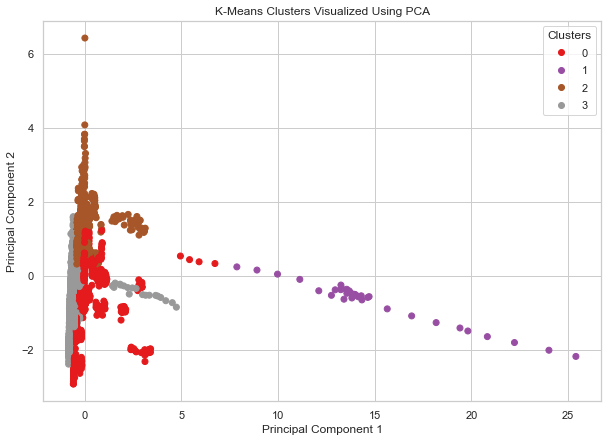

In [12]:
# Assuming 'features' contains the necessary columns for clustering and 'clusters' contains the cluster labels

# Step 1: Apply PCA for dimensionality reduction (reduce to 2D)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)  # Use scaled_features from the previous clustering process

# Step 2: Create a DataFrame for plotting
pca_df = pd.DataFrame(pca_features, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters  # Add the cluster labels

# Step 3: Plot the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='Set1')

# Adding labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clusters Visualized Using PCA')

# Add a color legend for the clusters
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


<div style="background-color: #e6f7ff; padding: 10px;">
The PCA (Principal Component Analysis) Is applied to reduce the dimensionality of the dataset, making the clusters more interpretable in a 2D space. The PCA plot helps visualize how countries group together based on the major contributing factors.
</div>

In [13]:
# Step 11: Display the updated summary table in a more readable format
print("Cluster Summary Table:")

# Format the DataFrame to show floats without scientific notation and round to two decimal places
pd.set_option('display.float_format', '{:,.2f}'.format)

# Assuming cluster_summary is a dictionary or similar data structure
# Convert your cluster_summary to a pandas DataFrame
cluster_summary_df = pd.DataFrame(cluster_summary)

# Display the dataframe with column names and formatted output
display(cluster_summary_df)  # Use display() for better rendering in Jupyter


Cluster Summary Table:


,Electricity from fossil fuels (TWh),Electricity from renewables (TWh),Electricity from nuclear (TWh),gdp_growth,Value_co2_emissions_kt_by_country,Energy intensity level of primary energy (MJ/$2017 PPP GDP),LatitudeCluster,PopulationDensityCluster,LandAreaCluster
Cluster,,,,,,,,,
0,59.87,22.92,23.20,3.22,"129,745.14",4.47,1.08,0.93,0.78
1,"3,131.94",717.94,498.70,5.18,"6,783,945.55",6.82,1.00,0.44,2.00
2,31.75,28.09,3.56,4.20,"82,818.60",6.43,0.09,0.16,1.70
3,20.11,4.36,0.46,4.07,"40,044.56",5.54,0.00,1.07,0.43


<div style="background-color: #e6f7ff; padding: 10px;">
The summary table reveals the average values for each key feature across the clusters. For example, Cluster 0 shows a balanced energy portfolio with moderate fossil fuel use and a significant share of renewables and nuclear energy. In contrast, Cluster 2 shows higher reliance on fossil fuels with much lower renewable energy use and higher CO2 emissions. These summaries highlight the energy challenges and opportunities in each cluster, providing insights into potential areas for policy interventions or investments in renewable energy development.
    </div>

<div style="background-color: #e6f7ff; padding: 10px;">
The K-Means clustering applied here divided countries into four clusters based on several key features: electricity composition (fossil fuels, renewables, and nuclear energy), CO2 emissions, GDP growth, energy intensity, and geographic features (latitude, population density, and land area). These clusters reveal distinctive patterns in energy use and economic growth across different regions and country types.

**Cluster 0**: Countries in this group, including many in Europe (e.g., Germany, France, and the UK) and parts of Asia (e.g., Japan, China), exhibit moderate to high levels of renewable and nuclear energy use, balanced with moderate fossil fuel reliance. These countries have relatively stable GDP growth and moderate CO2 emissions. They represent developed nations with diverse energy portfolios.

**Cluster 1**: The United States forms its own cluster, characterized by significantly higher energy consumption, particularly from fossil fuels, and a higher GDP growth rate. This reflects the unique energy consumption profile of a large, industrialized nation heavily reliant on fossil fuels, despite a growing renewable energy sector.

**Cluster 2**: This cluster includes many developing nations, particularly from Africa and parts of South America. These countries rely more heavily on fossil fuels, have lower renewable energy penetration, and face significant CO2 emissions challenges. Their economic growth rates tend to be higher, indicating a phase of industrial development, but energy transitions toward cleaner sources are slower.

**Cluster 3**: This group primarily consists of small island nations and lower-income countries. These countries have very low electricity consumption from fossil fuels and minimal reliance on nuclear energy. Their renewable energy use is growing but still limited, and they face low CO2 emissions due to their small size and relatively low industrial activity.
</div>

# 2.3.3 Financial Aid and Renewable Energy Growth

<div style="background-color: #e6f7ff; padding: 10px;">
This section evaluates how financial aid impacts renewable energy growth in developing countries. It is structured into three parts:

    1. Financial Aid Distribution: Analysis of which countries received financial aid between 2000 and 2020, highlighting the top 5 and bottom 5 recipients.

    2. Impact of Financial Aid: An OLS regression is used to assess whether past financial aid (up to past 4 yearly aids) has led to increased renewable energy shares, with GDP per capita and energy intensity as additional factors.
    
    3.Prediction of Renewable Energy Growth: Lasso and Random Forest models are employed to predict renewable energy share growth, capturing both linear and non-linear patterns.
    
This section combines regression analysis, machine learning models, and visualizations to understand the effect of financial aid and predict future renewable energy adoption trends.
</div>

# 2.3.3A Financial Aid Distribution

In [14]:
# Filter out rows where the "Financial flows to developing countries (US $)" is missing
financial_data = data.dropna(subset=[
    'Financial flows to developing countries (US $)',
    'Renewable energy share in the total final energy consumption (%)',
    'Value_co2_emissions_kt_by_country'
])




# Check the cleaned data
#print("Cleaned Data for Financial Flows and Renewable Energy:")
#print(financial_data[['Entity', 'Year', 'Financial flows to developing countries (US $)',
#                      'Renewable energy share in the total final energy consumption (%)',
#                      'Value_co2_emissions_kt_by_country']])

In [15]:
# Get the total number of unique countries with financial flow data
num_countries = financial_data['Entity'].nunique()

# Group the countries by region for a concise presentation
grouped_countries = financial_data.groupby('Region')['Entity'].apply(lambda x: ', '.join(sorted(x.unique())))


# Display the correct total number of countries
print(f"Number of countries receieved financial aids: {num_countries}")
print("Countries grouped by region:")

# Loop through the grouped countries by region and wrap the text for readability
for region, countries in grouped_countries.items():
    wrapped_countries = "\n".join(textwrap.wrap(countries, width=80))  # Wrap the text for better readability
    print(f"\n{region}:")
    print(wrapped_countries)


Number of countries receieved financial aids: 107
Countries grouped by region:

Africa:
Algeria, Angola, Benin, Botswana, Burkina Faso, Burundi, Cameroon, Central
African Republic, Chad, Comoros, Djibouti, Equatorial Guinea, Eritrea, Eswatini,
Ethiopia, Gabon, Ghana, Guinea, Guinea-Bissau, Kenya, Lesotho, Liberia,
Madagascar, Malawi, Mali, Mauritania, Mauritius, Morocco, Mozambique, Namibia,
Niger, Nigeria, Rwanda, Sao Tome and Principe, Senegal, Seychelles, Sierra
Leone, Somalia, South Africa, South Sudan, Sudan, Togo, Tunisia, Uganda, Zambia,
Zimbabwe

America:
Antigua and Barbuda, Argentina, Barbados, Belize, Brazil, Chile, Colombia, Costa
Rica, Cuba, Dominica, Dominican Republic, Ecuador, El Salvador, Grenada,
Guatemala, Guyana, Haiti, Honduras, Jamaica, Mexico, Nicaragua, Panama,
Paraguay, Peru, Suriname, Uruguay

Asia:
Afghanistan, Armenia, Azerbaijan, Bangladesh, Bhutan, Cambodia, China, Georgia,
India, Indonesia, Iraq, Jordan, Kazakhstan, Lebanon, Malaysia, Maldives,
Mongolia, 

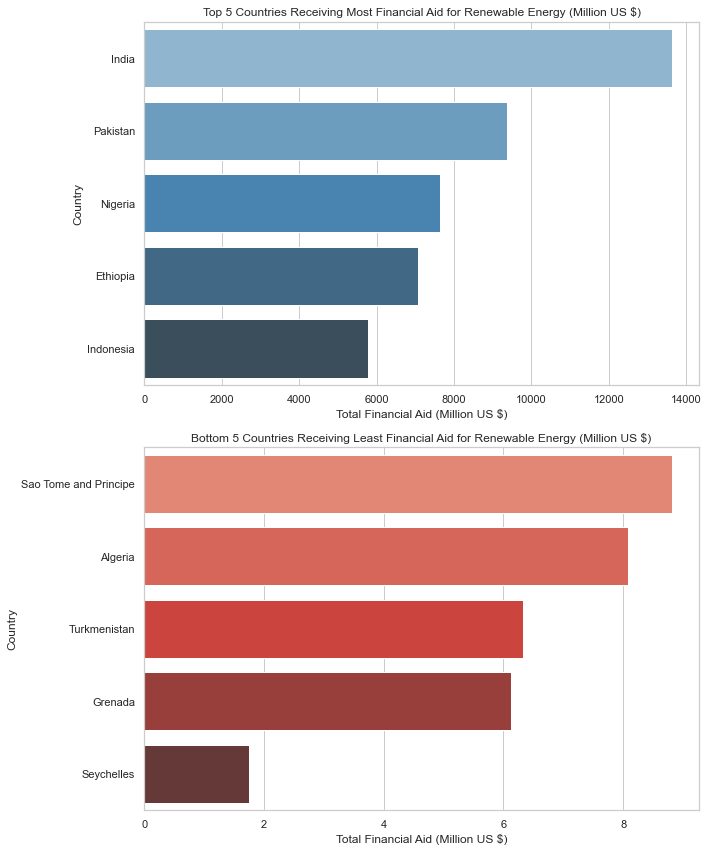

In [16]:
# Step 1: Group by 'Entity' (country) and calculate the total financial aid received across all years
total_aid_by_country = financial_data.groupby('Entity')['Financial flows to developing countries (US $)'].sum()

# Step 2: Sort the countries by the total financial aid received in descending order
total_aid_by_country_sorted = total_aid_by_country.sort_values(ascending=False)

# Step 3: Extract the top 5 and bottom 5 countries
top_countries = total_aid_by_country_sorted.head(5)
bottom_countries = total_aid_by_country_sorted.tail(5)

# Convert financial flows to millions for better readability in bar charts
top_countries_millions = top_countries / 1e6
bottom_countries_millions = bottom_countries / 1e6

# Step 4 and 5: Create a 2x1 subplot for the top and bottom 5 countries
plt.figure(figsize=(10, 12))  # Adjust the height for 2 rows

# Plot the top 5 countries receiving the most financial aid (1st subplot)
plt.subplot(2, 1, 1)
sns.barplot(x=top_countries_millions.values, y=top_countries_millions.index, palette="Blues_d")
plt.title('Top 5 Countries Receiving Most Financial Aid for Renewable Energy (Million US $)')
plt.xlabel('Total Financial Aid (Million US $)')
plt.ylabel('Country')

# Plot the bottom 5 countries receiving the least financial aid (2nd subplot)
plt.subplot(2, 1, 2)
sns.barplot(x=bottom_countries_millions.values, y=bottom_countries_millions.index, palette="Reds_d")
plt.title('Bottom 5 Countries Receiving Least Financial Aid for Renewable Energy (Million US $)')
plt.xlabel('Total Financial Aid (Million US $)')
plt.ylabel('Country')

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


<div style="background-color: #e6f7ff; padding: 10px;">
By checking the plots, the financial aid on clean energy projects received by developing countries from 2000 to 2020 is examined. The data reveals significant disparities in the distribution of financial flows, with certain regions receiving substantially more aid than others. The top recipients include countries like India, Pakistan and Nigeria. Conversely, smaller countries, particularly in Africa and Oceania, receive far less aid.
</div>

# 2.3.3B Impact of Financial Aid

<div style="background-color: #e6f7ff; padding: 10px;">

**Method:**
Ordinary Least Squares (OLS) regression is applied to assess the relationship between financial aid and renewable energy share among total energy consumption.

**Factors/Regressors Used:**
The regressors include yearly financial aid amounts and their 4 lagged past values, GDP per capita, and energy intensity, which were selected to determine how financial support, economic development, and energy efficiency influence renewable energy adoption. 
    
</div>

                                                   OLS Regression Results                                                   
Dep. Variable:     Renewable energy share in the total final energy consumption (%)   R-squared:                       0.394
Model:                                                                          OLS   Adj. R-squared:                  0.391
Method:                                                               Least Squares   F-statistic:                     156.4
Date:                                                              Sun, 29 Sep 2024   Prob (F-statistic):          3.58e-153
Time:                                                                      23:45:53   Log-Likelihood:                -6646.8
No. Observations:                                                              1453   AIC:                         1.331e+04
Df Residuals:                                                                  1446   BIC:                         1.334e+04


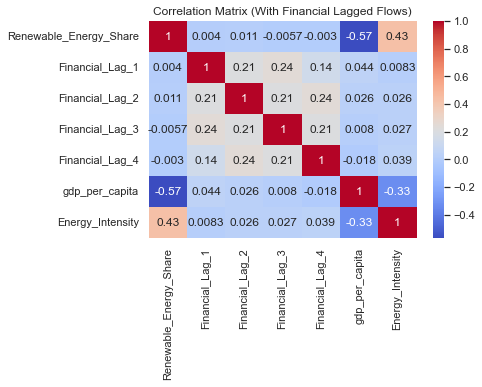

In [17]:
# Explicitly create a copy of the DataFrame to avoid SettingWithCopyWarning
financial_data_clean = financial_data.copy()

# Step 1: Create lagged versions of the financial flows variable (1 current + 4 past lags)
financial_data_clean.loc[:, 'Lagged_Financial_Flows_1'] = financial_data_clean['Financial flows to developing countries (US $)'].shift(1)
financial_data_clean.loc[:, 'Lagged_Financial_Flows_2'] = financial_data_clean['Financial flows to developing countries (US $)'].shift(2)
financial_data_clean.loc[:, 'Lagged_Financial_Flows_3'] = financial_data_clean['Financial flows to developing countries (US $)'].shift(3)
financial_data_clean.loc[:, 'Lagged_Financial_Flows_4'] = financial_data_clean['Financial flows to developing countries (US $)'].shift(4)

# Step 2: Drop any rows with missing values (after lagging)
financial_data_clean = financial_data_clean.dropna(subset=['Lagged_Financial_Flows_1', 'Lagged_Financial_Flows_2', 
                                                           'Lagged_Financial_Flows_3', 'Lagged_Financial_Flows_4', 
                                                           'gdp_per_capita', 
                                                           'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
                                                           'Renewable energy share in the total final energy consumption (%)'])

# Step 3: Prepare the independent variables (X) and dependent variable (y)
X = financial_data_clean[['Lagged_Financial_Flows_1', 
                          'Lagged_Financial_Flows_2', 
                          'Lagged_Financial_Flows_3', 
                          'Lagged_Financial_Flows_4',
                          'gdp_per_capita', 
                          'Energy intensity level of primary energy (MJ/$2017 PPP GDP)']]

y = financial_data_clean['Renewable energy share in the total final energy consumption (%)']

# Step 4: Add a constant (intercept) to the model
X = sm.add_constant(X)

# Step 5: Fit the OLS regression model with 5 lags
model = sm.OLS(y, X).fit()

# Step 6: Print the regression summary
print(model.summary())

# Step 7: Visualize the correlation matrix to check relationships between variables (including lagged flows)
correlation_matrix = financial_data_clean[['Renewable energy share in the total final energy consumption (%)', 
                                           'Lagged_Financial_Flows_1',  
                                           'Lagged_Financial_Flows_2',  
                                           'Lagged_Financial_Flows_3',  
                                           'Lagged_Financial_Flows_4',  
                                           'gdp_per_capita', 
                                           'Energy intensity level of primary energy (MJ/$2017 PPP GDP)']]

# Rename columns for better readability in the correlation matrix
correlation_matrix = correlation_matrix.rename(columns={
    'Renewable energy share in the total final energy consumption (%)': 'Renewable_Energy_Share',
    'Lagged_Financial_Flows_1': 'Financial_Lag_1',
    'Lagged_Financial_Flows_2': 'Financial_Lag_2',
    'Lagged_Financial_Flows_3': 'Financial_Lag_3',
    'Lagged_Financial_Flows_4': 'Financial_Lag_4',
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)': 'Energy_Intensity'
}).corr()

# Step 8: Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (With Financial Lagged Flows)')
plt.show()


<div style="background-color: #e6f7ff; padding: 10px;">
The OLS regression model was employed to assess whether financial aid has effectively contributed to increasing the share of renewable energy in these developing countries. The results show a positive, but modest, relationship between past financial aid and renewable energy growth. However, GDP per capita and energy intensity were stronger predictors of renewable energy adoption, suggesting that financial aid alone is insufficient for driving significant energy transitions. Economic growth and energy efficiency also play crucial roles in enabling renewable energy adoption.
</div>

# 2.3.3C Prediction of Renewable Energy Growth

The same regressors used in the OLS model were now applied for prediction purposes, utilizing two popular models: Random Forest (RF) and Lasso. Their performance was examined on a renewable energy share prediction task.

In [18]:
# Step 1: Create a copy of financial_data to avoid SettingWithCopyWarning
financial_data_clean = financial_data.copy()

# Create lagged versions of the financial flows variable (1 current + 4 past lags)
financial_data_clean['Lagged_Financial_Flows_1'] = financial_data_clean['Financial flows to developing countries (US $)'].shift(1)
financial_data_clean['Lagged_Financial_Flows_2'] = financial_data_clean['Financial flows to developing countries (US $)'].shift(2)
financial_data_clean['Lagged_Financial_Flows_3'] = financial_data_clean['Financial flows to developing countries (US $)'].shift(3)
financial_data_clean['Lagged_Financial_Flows_4'] = financial_data_clean['Financial flows to developing countries (US $)'].shift(4)

# Step 2: Drop any rows with missing values (after lagging)
financial_data_clean = financial_data_clean.dropna(subset=['Lagged_Financial_Flows_1', 'Lagged_Financial_Flows_2', 
                                                           'Lagged_Financial_Flows_3', 'Lagged_Financial_Flows_4', 
                                                           'gdp_per_capita', 
                                                           'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
                                                           'Renewable energy share in the total final energy consumption (%)'])

# Step 3: Prepare the independent variables (X) and dependent variable (y)
X = financial_data_clean[['Lagged_Financial_Flows_1', 
                          'Lagged_Financial_Flows_2', 
                          'Lagged_Financial_Flows_3', 
                          'Lagged_Financial_Flows_4',
                          'gdp_per_capita', 
                          'Energy intensity level of primary energy (MJ/$2017 PPP GDP)']]

y = financial_data_clean['Renewable energy share in the total final energy consumption (%)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Lasso Regression #
lasso = Lasso(alpha=0.1)  # Adjust alpha based on regularization needs
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Step 5: Random Forest Regression #
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)




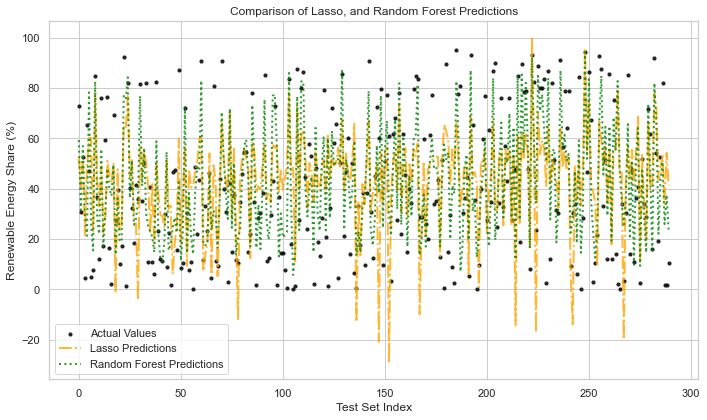

In [19]:
# Plot actual VS predicted values
n_points = 290  # You can adjust this value based on the data size

plt.figure(figsize=(10, 6))

# Plot actual values as scatter with larger marker size for visibility
plt.scatter(range(n_points), y_test.values[:n_points], label='Actual Values', color='black', s=10, alpha=0.8)

# Plot the model predictions as curves (lines) with transparency (alpha)
plt.plot(range(n_points), y_pred_lasso[:n_points], label='Lasso Predictions', linestyle='-.', color='orange', alpha=0.8, linewidth=2)
plt.plot(range(n_points), y_pred_rf[:n_points], label='Random Forest Predictions', linestyle=':', color='green', alpha=0.8, linewidth=2)

plt.title('Comparison of Lasso, and Random Forest Predictions')
plt.xlabel('Test Set Index')
plt.ylabel('Renewable Energy Share (%)')
plt.legend()

plt.tight_layout()
plt.show()

<div style="background-color: #e6f7ff; padding: 10px;">
The plot above compares the predictions of Random Forest and Lasso on 20% of the total data, where the black dots represent the original data points. 
    </div>

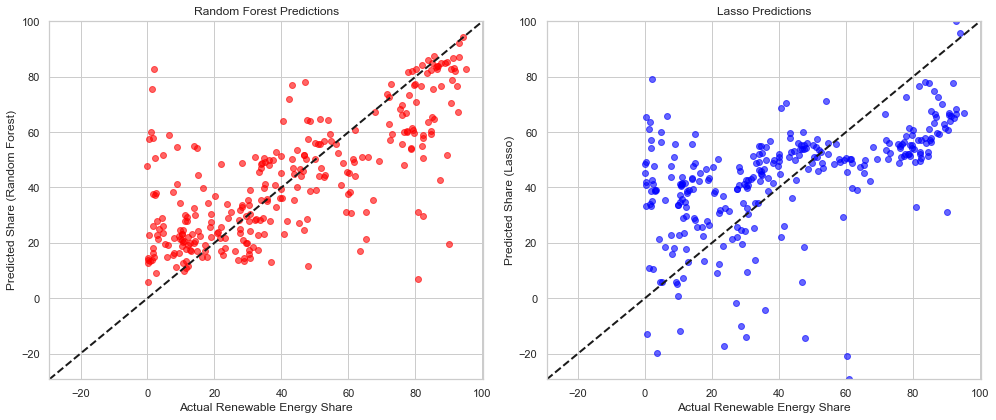

In [20]:
# Define y-axis limits for consistency across both plots
y_min = min(y_test.min(), y_pred_rf.min(), y_pred_lasso.min())
y_max = max(y_test.max(), y_pred_rf.max(), y_pred_lasso.max())

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Random Forest
axes[0].scatter(y_test, y_pred_rf, alpha=0.6, color='red')
axes[0].plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)  # 45-degree line
axes[0].set_xlabel('Actual Renewable Energy Share')
axes[0].set_ylabel('Predicted Share (Random Forest)')
axes[0].set_title('Random Forest Predictions')
axes[0].set_ylim(y_min, y_max)
axes[0].set_xlim(y_min, y_max)

# Plot for Lasso
axes[1].scatter(y_test, y_pred_lasso, alpha=0.6, color='blue')
axes[1].plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)  # 45-degree line
axes[1].set_xlabel('Actual Renewable Energy Share')
axes[1].set_ylabel('Predicted Share (Lasso)')
axes[1].set_title('Lasso Predictions')
axes[1].set_ylim(y_min, y_max)
axes[1].set_xlim(y_min, y_max)

# Tight layout for better spacing between plots
plt.tight_layout()
plt.show()


<div style="background-color: #e6f7ff; padding: 10px; margin-bottom: 10px;">
The two plot above compares the predicted vs. actual values of renewable energy share for both models, with closer alignment to the 45-degree line indicating better prediction accuracy.
</div>

<div style="background-color: #e6f7ff; padding: 10px;">
It is evident that Random Forest performs better because most of the predicted points are closer to the 45-degree line, which indicates perfect predictions (where predicted values match actual values). In contrast, Lasso shows more deviation from this line. Additionally, Lasso produced negative predictions for renewable energy share in some cases, which is impossible since a share cannot be negative. This further demonstrates that Random Forest is much more effective at predicting renewable energy share in total energy consumption.
</div>

In [21]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Evaluate Model Performance ###

# Lasso Evaluation
rmse_lasso = rmse(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Random Forest Evaluation
rmse_rf = rmse(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Display evaluation metrics
print(f"Lasso - RMSE: {rmse_lasso}, MAE: {mae_lasso}, R-squared: {r2_lasso}")
print(f"Random Forest - RMSE: {rmse_rf}, MAE: {mae_rf}, R-squared: {r2_rf}")

### Calculate Relevant Info of Test Set ###

# Statistics for actual test set values
mean_y_test = np.mean(y_test)
std_y_test = np.std(y_test)
min_y_test = np.min(y_test)
max_y_test = np.max(y_test)

# Statistics for predicted values
mean_pred_lasso = np.mean(y_pred_lasso)
mean_pred_rf = np.mean(y_pred_rf)

# Display statistics of the actual test set
print("\nTest Set Statistics:")
print(f"Mean of Actual Test Set: {mean_y_test}")
print(f"Standard Deviation of Actual Test Set: {std_y_test}")
print(f"Min of Actual Test Set: {min_y_test}")
print(f"Max of Actual Test Set: {max_y_test}")

Lasso - RMSE: 25.275992580077023, MAE: 20.404112959803193, R-squared: 0.23653507820249564
Random Forest - RMSE: 19.839300481278585, MAE: 14.176516151202751, R-squared: 0.5296454389941356

Test Set Statistics:
Mean of Actual Test Set: 41.30920962199314
Standard Deviation of Actual Test Set: 28.927684709880793
Min of Actual Test Set: 0.0
Max of Actual Test Set: 95.15


<div style="background-color: #e6f7ff; padding: 10px;">
    
Random Forest significantly outperforms Lasso based on key metrics such as RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error), which measure how far off the model's predictions are from the actual data. Lower values of RMSE and MAE indicate that the Random Forest model makes fewer and smaller errors compared to Lasso. Additionally, Random Forest has a much better R-squared value, which indicates how well the model explains the variability in the data.

    
    
However, despite Random Forest's better performance, its RMSE is still relatively high compared to the overall variability (standard deviation) in the test data, meaning there's room for improvement in prediction accuracy. Lasso, with its low R-squared and higher errors, suggests that it is not well-suited for this dataset. The higher error and poor fit are likely due to Lasso's tendency to over-regularize, meaning it simplifies the model too much and loses important details.

While Random Forest is clearly the better choice, it can be further improved by fine-tuning its parameters to reduce prediction errors even more.
    
</div>

# 3. Conclusion

<div style="background-color: #e6f7ff; padding: 10px; ">
This project analyzed global energy trends from 2000 to 2020, using a comprehensive dataset that covers energy access, electricity composition, financial flows, and economic factors. The focus was on examining disparities across regions, clustering countries based on energy profiles, and assessing the impact of financial aid on renewable energy development in developing countries.
</div>

<div style="background-color: #e6f7ff; padding: 10px; ">
    Major Findings:

    1. How has access to electricity and clean cooking fuels evolved from 2000 to 2020 across selected categories, and what is the potential for growth?
    
    The analysis revealed significant progress in energy access, particularly in regions like the Americas and Europe. However, large disparities remain, with regions such as Africa and Oceania still lagging in both electricity access and clean cooking fuel availability.
    
    Additionally, the potential analysis using 2020 data identified regions with high renewable energy potential but low current access, highlighting key areas for future investments and energy policy interventions.

    2. How does electricity composition vary across regions, and can countries be clustered into meaningful categories based on additional features?
    
    The electricity composition analysis showed a wide variance in energy sources across regions. Europe and parts of Asia exhibit a balanced mix of fossil fuels, renewables, and nuclear energy, while Africa and America remain highly dependent on fossil fuels.
    
    The K-Means clustering applied using a combination of electricity sources, CO2 emissions, GDP growth, and geographic factors grouped countries into distinct clusters. This revealed countries with similar energy challenges, such as high reliance on fossil fuels and low renewable energy adoption, providing insights for targeted policy recommendations.

    3. How have developing countries that received financial aid for renewable energy development performed, and what can be predicted for future growth?
    
    First, the analysis identified the top 5 and bottom 5 developing countries that received financial aid between 2000 and 2020, showing that larger economies like India received the most aid, while smaller nations received less.
    
    Second, OLS regression revealed that while financial aid positively impacted renewable energy adoption, structural factors such as GDP per capita and energy intensity played a larger role in driving renewable energy growth.
    
    Finally, predictive modeling using Lasso and Random Forest showed that the latter performed significantly better in predicting renewable energy share growth, as it better captured non-linear patterns. The Lasso model struggled, even producing negative predictions for some countries, which is not feasible for renewable energy share.
</div>